In [1]:
pip install pytorch-pretrained-bert

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import os, sys
import json
import matplotlib.pyplot as plt
import pandas as pd
import string
import torch

from collections import defaultdict
from random import sample 
from torch.nn import functional as F
from pytorch_pretrained_bert import  GPT2Tokenizer, GPT2LMHeadModel, BertTokenizer, BertForPreTraining, OpenAIAdam

sys.path.insert(0, "/content/gdrive/My Drive/Project-Lion/") 
root_folder = "/content/gdrive/My Drive/Project-Lion/"

In [0]:
def clean_data(lst, in_place=True, keep_punc=""):
    if in_place:
        new_lst = lst
    else:
        new_lst = lst.copy()
        
    for i in range(len(new_lst)):
        joke = lst[i]
        joke = joke.replace("\r", " ").replace("\n", " ").replace("/", " or ")
        punc_to_remove = string.punctuation
        for punc in keep_punc:
          punc_to_remove = punc_to_remove.replace(punc, "")
        joke = joke.translate(str.maketrans("", "", punc_to_remove)) # Remove punctuation
        joke = joke.lower() # Lowercase
        joke = joke.strip() # Remove leading and ending whitespace
        new_lst[i] = joke
    return new_lst

In [0]:
df = pd.read_csv(root_folder + 'data/kaggle/shortjokes.csv')
df = df.loc[df["Joke"] != ""]

In [6]:
data = clean_data(df["Joke"].tolist(), keep_punc="?,':.")
print("Length of data:", len(data))
print(data[0])

Length of data: 231657
me narrating a documentary about narrators i can't hear what they're saying cuz i'm talking


# GPT

In [0]:
best_path = root_folder + "gpt_output/gpt_finetuning/best_model.pt"
best_losses_path = root_folder + "gpt_output/gpt_finetuning/best_losses"
latest_path = root_folder + "gpt_output/gpt_finetuning/latest_model.pt"
latest_losses_path = root_folder + "gpt_output/gpt_finetuning/latest_losses"
jokes_output_path = root_folder + "gpt_output/jokes_output.txt"

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
saved_model = GPT2LMHeadModel.from_pretrained('gpt2')
optimizer = OpenAIAdam(model.parameters(), lr=0.001)
iteration = 1
losses = []

t_total value of -1 results in schedule not being applied


In [0]:
gpt_data = defaultdict(list) # Map from length of data -> list of data
for d in data:
  tokens = tokenizer.encode(d)
  if len(tokens) > 6 and len(tokens) < 50:
    gpt_data[len(tokens)].append(tokens)

gpt_data = dict(gpt_data)
gpt_data_lens = list(gpt_data.keys())
weighted_gpt_data_lens = []
for lens in gpt_data_lens:
  weighted_gpt_data_lens.extend([lens] * len(gpt_data[lens]))

In [10]:
a = []
for lens in gpt_data_lens:
  a.append((lens, len(gpt_data[lens])))
  
min_tup = min(a, key=lambda x: x[1])
  
print("Length with smallest batch: {0}. Length of batch: {1}".format(min_tup[0], min_tup[1]))

Length with smallest batch: 49. Length of batch: 265


## Load Previous Latest model

Run to load most recent model to continue training

In [0]:
checkpoint = torch.load(latest_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
iteration = checkpoint['iteration'] + 1
loss = checkpoint['loss']
losses = np.load(latest_losses_path + ".npy").tolist()

## Training

In [0]:
batch_size = 32
evaluation_batch_size = 128
keep_model_trials = 3
epochs = 20
iterations_per_epoch = 1000
total_iterations = (iterations_per_epoch * epochs) + iteration - 1

for epoch in range(1, epochs + 1):
  for _ in range(iterations_per_epoch):

    length = np.random.choice(weighted_gpt_data_lens)
    batch_input = torch.tensor(sample(gpt_data[length], batch_size))

    loss = model(batch_input, lm_labels=batch_input)
    losses.append((iteration, loss.data.item()))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iteration % 10 == 0:
      print("Iteration {0}/{1}: Loss - {2}".format(str(iteration), total_iterations, str(loss.data.item())))
      
    if iteration % 100 == 0:
      curr_loss, saved_loss = 0, 0
      for _ in range(keep_model_trials):
        length = np.random.choice(weighted_gpt_data_lens)
        batch_input = torch.tensor(sample(gpt_data[length], batch_size))

        checkpoint = torch.load(best_path)
        saved_model.load_state_dict(checkpoint['model_state_dict'])
        saved_model_loss = saved_model(batch_input, lm_labels=batch_input).data.item()
        model_loss = model(batch_input, lm_labels=batch_input).data.item()

        curr_loss, saved_loss = curr_loss + model_loss, saved_loss + saved_model_loss
      
      avg_curr_loss, avg_saved_loss = curr_loss / keep_model_trials, saved_loss / keep_model_trials
      loss_str = "Average current model loss: {0}. Average saved model loss: {1}. ".format(avg_curr_loss, avg_saved_loss)
      
      if avg_curr_loss < avg_saved_loss:
        print(loss_str + "Updating best model.")
        torch.save({
              'epoch': epoch,
              'iteration': iteration,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss
              }, best_path)
        
        np.save(best_losses_path, losses)
      
      else:
        print(loss_str + "Keeping previous best model.")
        
      torch.save({
            'epoch': epoch,
            'iteration': iteration,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, latest_path)
      
      np.save(latest_losses_path, losses)
        
    iteration += 1
    

Iteration 11810/31800: Loss - 2.4688174724578857
Iteration 11820/31800: Loss - 2.8700003623962402
Iteration 11830/31800: Loss - 2.422269582748413
Iteration 11840/31800: Loss - 2.679527759552002
Iteration 11850/31800: Loss - 3.059194803237915
Iteration 11860/31800: Loss - 2.8438401222229004
Iteration 11870/31800: Loss - 2.642218828201294


## Plot

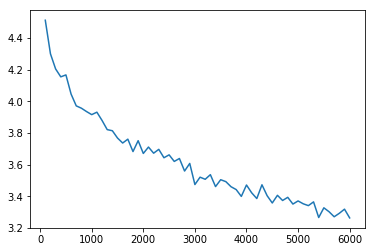

In [0]:
x = []
y, y_sum = [], []
for a, b in losses:
  y_sum.append(b)
  if a % 100 == 0:
    x.append(a)
    y.append(sum(y_sum) / 100)
    y_sum = []
plt.plot(x, y)
plt.show()

## Evaluation

In [0]:
checkpoint = torch.load(best_path)
saved_model.load_state_dict(checkpoint['model_state_dict'])

In [12]:
checkpoint['iteration']

15200

In [0]:
batch_size = 128
length = np.random.choice(weighted_gpt_data_lens)
batch_input = torch.tensor(sample(gpt_data[length], batch_size))
saved_model_loss = saved_model(batch_input, lm_labels=batch_input).data.item()
print(saved_model_loss)

3.2254347801208496


## Generate Text

In [32]:
text = tokenizer.encode("what")
input, past = torch.tensor([text]), None
for _ in range(30):
  logits, past = saved_model(input, past=past)
  input = torch.multinomial(F.softmax(logits[:, -1]), 1)
  text.append(input.item())

joke = tokenizer.decode(text)
print(joke)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


what do you call a meatsculative potato? asian golden. apologies to the aged senior billiard player for retiring the king of england mine inspirational


In [0]:
f = open(jokes_output_path, "w")
f.write("Jokes generated starting with 'why':\n")
for i in range(100):
  text = tokenizer.encode("why")
  input, past = torch.tensor([text]), None
  for _ in range(30):
    logits, past = saved_model(input, past=past)
    input = torch.multinomial(F.softmax(logits[:, -1]), 1)
    text.append(input.item())

  joke = tokenizer.decode(text)
  f.write(joke + "\n")
  print(joke)
  
f.write("\n")
f.write("Jokes generated starting with 'how':\n")
for i in range(100):
  text = tokenizer.encode("how")
  input, past = torch.tensor([text]), None
  for _ in range(30):
    logits, past = saved_model(input, past=past)
    input = torch.multinomial(F.softmax(logits[:, -1]), 1)
    text.append(input.item())

  joke = tokenizer.decode(text)
  f.write(joke + "\n")
  print(joke)
  
f.close()

In [33]:
f = open(jokes_output_path, "a")
f.write("\n")
f.write("Jokes generated starting with 'what':\n")
for i in range(100):
  text = tokenizer.encode("what")
  input, past = torch.tensor([text]), None
  for _ in range(30):
    logits, past = saved_model(input, past=past)
    input = torch.multinomial(F.softmax(logits[:, -1]), 1)
    text.append(input.item())

  joke = tokenizer.decode(text)
  f.write(joke + "\n")
  print(joke)
  
f.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


what do you call a jewish centre? challah at ya zik cuz of ya zik cuz i'll show myself out. what do
what's the difference between a tuna and a whoremonica? a whoremonica makes everyone happy. a bitchmonica makes everyone happy. a bitch
what do you call a very small beak? a beak, if you enjoy it congratulations. from now on dude, if you keep the orange me
what did the former porn actor say when he lost his job after having sex in a porn studio? that's the right the fucking joke. what did him
what do you call a masterbating german baker? the potatoburger. i'll just here now.  what a chuckle goes out between he
what's charlie sheen's favorite beer? two mature blackbullies. ...heheheheheheheheay there's your turn.
what do you call a cheap circumcision? a rip off. : http: or  or www.youtube.com or watch?vrgkpxod
what did the paraplegic cow say? mbaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa na na na na na
what's a moo's favorite nursery rhyme?  bacon stroganoff. sorry reddit op

# BERT

In [0]:
!python /content/gdrive/My\ Drive/Project-Lion/pytorch-pretrained-BERT-master/examples/lm_finetuning/simple_lm_finetuning.py --train_corpus gdrive/My\ Drive/Project-Lion/bert_training_data.txt --bert_model bert-base-uncased --num_train_epochs 4.0 --do_lower_case --output_dir gdrive/My\ Drive/Project-Lion/gpt_output/ --do_train

Traceback (most recent call last):
  File "/content/gdrive/My Drive/Project-Lion/pytorch-pretrained-BERT-master/examples/lm_finetuning/simple_lm_finetuning.py", line 34, in <module>
    from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear
ImportError: cannot import name 'warmup_linear'


In [0]:
model = BertForPreTraining.from_pretrained(root_folder + "gpt_output/")

In [0]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer = bert_tokenizer.basic_tokenizer

In [0]:
tokens = tokenizer.tokenize("Why did the chicken")

In [0]:
ids = bert_tokenizer.convert_tokens_to_ids(tokens)

In [0]:
text = []
input = torch.tensor([ids])
output1, output2 = model(input)
print(output1.shape)
a = torch.multinomial(F.softmax(output1[:, 3]), 1)
text.append(a.item())
print(text)
print(bert_tokenizer.convert_ids_to_tokens(text))

torch.Size([1, 4, 50257])
[13]
['[unused12]']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


# Etc

In [0]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [0]:
text = tokenizer.encode("why did the chicken cross the road?")
input, past = torch.tensor([text]), None
for _ in range(20):
  logits, past = model(input, past=past)
  print(logits.shape)
  input = torch.multinomial(F.softmax(logits[:, -1]), 1)
  text.append(input.item())
  
tokenizer.decode(text)

torch.Size([1, 8, 50257])
tensor([[383]])
torch.Size([1, 1, 50257])
tensor([[22045]])
torch.Size([1, 1, 50257])
tensor([[373]])
torch.Size([1, 1, 50257])
tensor([[881]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


torch.Size([1, 1, 50257])
tensor([[4025]])
torch.Size([1, 1, 50257])
tensor([[621]])
torch.Size([1, 1, 50257])
tensor([[257]])
torch.Size([1, 1, 50257])
tensor([[22045]])
torch.Size([1, 1, 50257])
tensor([[11]])
torch.Size([1, 1, 50257])
tensor([[475]])
torch.Size([1, 1, 50257])
tensor([[550]])
torch.Size([1, 1, 50257])
tensor([[2440]])
torch.Size([1, 1, 50257])
tensor([[28071]])
torch.Size([1, 1, 50257])
tensor([[286]])
torch.Size([1, 1, 50257])
tensor([[23115]])
torch.Size([1, 1, 50257])
tensor([[9423]])
torch.Size([1, 1, 50257])
tensor([[1802]])
torch.Size([1, 1, 50257])
tensor([[4]])
torch.Size([1, 1, 50257])
tensor([[286]])
torch.Size([1, 1, 50257])
tensor([[7409]])


'why did the chicken cross the road? The duck was much larger than a duck, but had higher percentages of Lacbec 100% of hyd'